In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import loadmat
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Entropy of Real Cell

In [3]:
def Entropy(rstate, binnum, overlap = True):
    rstate[rstate>1] = 1
    wordsCollection = []
    if overlap:
        for i in np.arange(0,len(rstate)-binnum+1):
            wordsCollection.append(rstate[i:i+binnum])
    else:
        for i in np.arange(0,len(rstate)-binnum+1,binnum):
            wordsCollection.append(rstate[i:i+binnum])
    _, index = np.unique(np.array(wordsCollection), axis = 0, return_inverse=True)
    N, _ = np.histogram(index,bins=np.append(np.unique(index),max(index)))
    P = N/np.sum(N)
    entropy = -np.sum(P*np.log2(P))
    return entropy

# Load files

In [4]:
dt = 0.01
exp_folder = 'D:\\GoogleDrive\\retina\\Exps\\2021\\1103\\SplitData\\'
Mean_list = [1,4,7,10,13]
Contrast_list = [0.05,0.1,0.2,0.3]

Data2DList = [[{} for c in Contrast_list] for m in Mean_list]
for mi in range(len(Mean_list)):
    for ci in range(len(Contrast_list)):
        filename = 'diode_repeat_OU_tau=500ms_cutoff=1_mean='+str(Mean_list[mi])+'_C='+str(Contrast_list[ci])+'_03-Nov-2021_0'
        annots = loadmat(exp_folder+filename, squeeze_me = True)
        sampling_rate = 20000
        TimeStamps = annots['TimeStamps']
        x = annots['a_data'][0, int(TimeStamps[0]*sampling_rate):int(TimeStamps[1]*sampling_rate)+1]
        x = x[::int(sampling_rate*dt)]
        x = x.astype(float)
        x = (x-np.mean(x))/np.std(x)
        T = np.arange(len(x))*dt

        Spike_Cell = [0]*60
        for channelnumber in np.arange(1,61):
            Spike = annots['Spikes'][channelnumber-1]
            try:
                Spike_Cell[channelnumber-1] = Spike[np.where(Spike>TimeStamps[0])[0][0]:np.where(Spike<TimeStamps[1])[0][-1]]-TimeStamps[0]
            except: # no spike
                Spike_Cell[channelnumber-1] = np.array([])

        Data2DList[mi][ci]['Mean'] = Mean_list[mi]
        Data2DList[mi][ci]['Contrast'] = Contrast_list[ci]
        Data2DList[mi][ci]['input'] = x.copy()
        Data2DList[mi][ci]['timeAxis'] = T.copy()
        Data2DList[mi][ci]['Spike_Cell'] = Spike_Cell.copy()

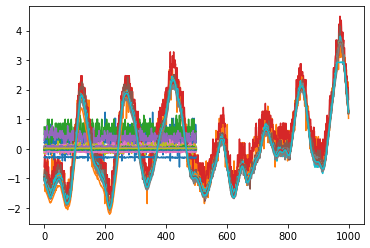

In [5]:
restTime = 5
stiTime = 10
trial = 20

for data in np.array(Data2DList).flatten():
    x = data['input']
    plt.plot(x[:int(restTime/dt)])
    plt.plot(x[int(restTime/dt):int((restTime+stiTime)/dt)])

# Information (R_info)

In [6]:
def R_info(rstate_trial, binnum, overlap = False):
    rstate_trial = np.array(rstate_trial)
    wordsCollection = []
    for rstate in rstate_trial:
        rstate[rstate>1] = 1
        if overlap:
            for i in np.arange(0,len(rstate)-binnum+1):
                wordsCollection.append(rstate[i:i+binnum])
        else:
            for i in np.arange(0,len(rstate)-binnum+1,binnum):
                wordsCollection.append(rstate[i:i+binnum])
    _, index = np.unique(np.array(wordsCollection), axis = 0, return_inverse=True)
    N, _ = np.histogram(index,bins=np.append(np.unique(index),max(index)))
    P = N/np.sum(N)
    totalEntropy = -np.sum(P*np.log2(P))

    trial_num = rstate_trial.shape[0]
    event_num = int(len(wordsCollection)/rstate_trial.shape[0])

    subEntropy = 0
    for i in range(event_num):
        subSet = []
        for j in range(trial_num):
            subSet.append(wordsCollection[event_num*j+i])
        _, index = np.unique(np.array(subSet), axis = 0, return_inverse=True)
        N, _ = np.histogram(index,bins=np.append(np.unique(index),max(index)))
        P = N/np.sum(N)
        subEntropy += -np.sum(P*np.log2(P))
    
    noiseEntropy = subEntropy/event_num
    return totalEntropy, noiseEntropy

In [7]:
binLen = dt/10
binNum = 10

## Cut Trial (Stimulus)

In [8]:
for mi in range(len(Mean_list)):
    for ci in range(len(Contrast_list)):
        Spike_Cell = Data2DList[mi][ci]['Spike_Cell'].copy()

        totalEntropy_Cell = [0]*60
        noiseEntropy_Cell = [0]*60
        for cn in range(60):
            Spike = Spike_Cell[cn]

            rstate_Trial = [0]*trial
            for i in range(trial):
                startTime = restTime+i*(restTime+stiTime)
                endTime = (i+1)*(restTime+stiTime)
                try:
                    Spike_Trial = Spike[np.where(Spike>=startTime)[0][0]:np.where(Spike<endTime)[0][-1]]-startTime
                    rstate_Trial[i], _ = np.histogram(Spike_Trial, np.arange(0,stiTime+binLen,binLen))
                except: # if there is no spike
                    rstate_Trial[i] = np.zeros(int(stiTime/binLen)+1)

            totalEntropy_Cell[cn], noiseEntropy_Cell[cn] = R_info(rstate_Trial, binNum)

        Data2DList[mi][ci]['totalEntropy_Cell'] = np.array(totalEntropy_Cell)
        Data2DList[mi][ci]['noiseEntropy_Cell'] = np.array(noiseEntropy_Cell)

Text(0, 0.5, 'information (bit)')

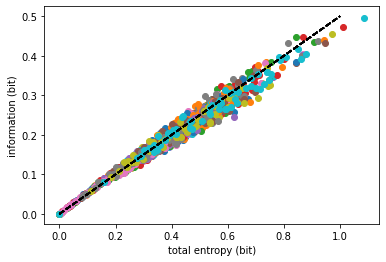

In [9]:
for data in np.array(Data2DList).flatten():
    totalEntropy_Cell = data['totalEntropy_Cell']
    noiseEntropy_Cell = data['noiseEntropy_Cell']
    plt.scatter(totalEntropy_Cell,totalEntropy_Cell-noiseEntropy_Cell)
    plt.plot([0, 1.], [0, 0.5], 'k--')
plt.xlabel('total entropy (bit)')
plt.ylabel('information (bit)')

## Cut Trial (Rest)

In [10]:
for mi in range(len(Mean_list)):
    for ci in range(len(Contrast_list)):
        Spike_Cell = Data2DList[mi][ci]['Spike_Cell']
        
        rest_totalEntropy_Cell = [0]*60
        rest_noiseEntropy_Cell = [0]*60
        for cn in range(60):
            Spike = Spike_Cell[cn]

            Spike_Trial = [0]*trial
            rstate_Trial = [0]*trial
            for i in range(trial):
                startTime = i*(restTime+stiTime)
                endTime = restTime+i*(restTime+stiTime)
                try:
                    Spike_Trial = Spike[np.where(Spike>=startTime)[0][0]:np.where(Spike<endTime)[0][-1]]-startTime
                    rstate_Trial[i], _ = np.histogram(Spike_Trial, np.arange(0,stiTime+binLen,binLen))
                except: # if there is no spike
                    rstate_Trial[i] = np.zeros(int(stiTime/binLen)+1)

            rest_totalEntropy_Cell[cn], rest_noiseEntropy_Cell[cn] = R_info(rstate_Trial, binNum)

        Data2DList[mi][ci]['rest_totalEntropy_Cell'] = np.array(rest_totalEntropy_Cell)
        Data2DList[mi][ci]['rest_noiseEntropy_Cell'] = np.array(rest_noiseEntropy_Cell)

Text(0, 0.5, 'information (bit)')

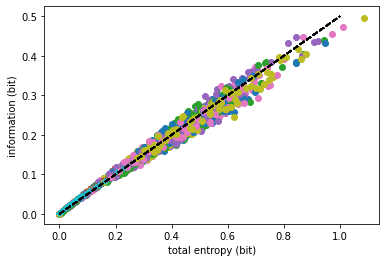

In [11]:
for data in np.array(Data2DList).flatten():
    totalEntropy_Cell = data['totalEntropy_Cell']
    noiseEntropy_Cell = data['noiseEntropy_Cell']
    plt.scatter(totalEntropy_Cell,totalEntropy_Cell-noiseEntropy_Cell)

    rest_totalEntropy_Cell = data['rest_totalEntropy_Cell']
    rest_noiseEntropy_Cell = data['rest_noiseEntropy_Cell']
    plt.scatter(rest_totalEntropy_Cell,rest_totalEntropy_Cell-rest_noiseEntropy_Cell, marker='+')
    plt.plot([0, 1.], [0, 0.5], 'k--')
plt.xlabel('total entropy (bit)')
plt.ylabel('information (bit)')

# DCCM

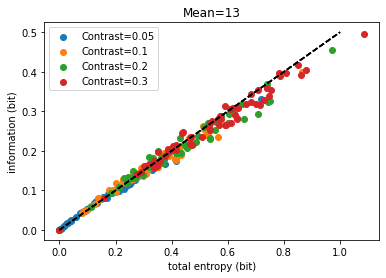

In [12]:
mi = 4
for ci in range(len(Contrast_list)):
    totalEntropy_Cell = Data2DList[mi][ci]['totalEntropy_Cell']
    noiseEntropy_Cell = Data2DList[mi][ci]['noiseEntropy_Cell']
    plt.scatter(totalEntropy_Cell,totalEntropy_Cell-noiseEntropy_Cell, label = 'Contrast='+str(Contrast_list[ci]))
    plt.plot([0, 1.], [0, 0.5], 'k--')
plt.xlabel('total entropy (bit)')
plt.ylabel('information (bit)')
plt.title('Mean='+str(Mean_list[mi]))
plt.legend()

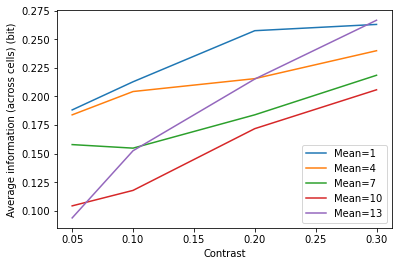

In [13]:
for mi in range(len(Mean_list)):
    mean_totalEntropy = np.zeros(len(Contrast_list))
    mean_noiseEntropy = np.zeros(len(Contrast_list))
    for ci in range(len(Contrast_list)):
        mean_totalEntropy[ci] = np.mean(np.array(Data2DList[mi][ci]['totalEntropy_Cell']))
        mean_noiseEntropy[ci] = np.mean(np.array(Data2DList[mi][ci]['noiseEntropy_Cell']))
    # plt.plot(Contrast_list,mean_totalEntropy, label = 'Mean='+str(Mean_list[mi]))
    plt.plot(Contrast_list, mean_totalEntropy-mean_noiseEntropy, label = 'Mean='+str(Mean_list[mi]))
    # plt.plot(Contrast_list, (mean_totalEntropy-mean_noiseEntropy)/mean_totalEntropy , label = 'Mean='+str(Mean_list[mi]))
plt.xlabel('Contrast')
plt.ylabel('Average information (across cells) (bit)')
plt.legend()

# CCDM

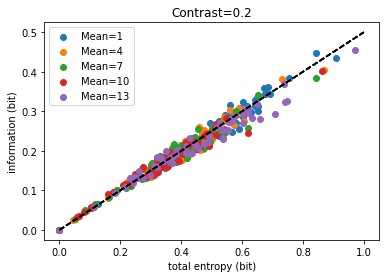

In [14]:
ci = 2
for mi in range(len(Mean_list)):
    totalEntropy_Cell = Data2DList[mi][ci]['totalEntropy_Cell']
    noiseEntropy_Cell = Data2DList[mi][ci]['noiseEntropy_Cell']
    plt.scatter(totalEntropy_Cell,totalEntropy_Cell-noiseEntropy_Cell, label = 'Mean='+str(Mean_list[mi]))
    plt.plot([0, 1.], [0, 0.5], 'k--')
plt.xlabel('total entropy (bit)')
plt.ylabel('information (bit)')
plt.title('Contrast='+str(Contrast_list[ci]))
plt.legend()

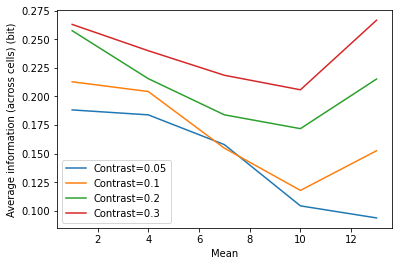

In [15]:
for ci in range(len(Contrast_list)):
    mean_totalEntropy = np.zeros(len(Mean_list))
    mean_noiseEntropy = np.zeros(len(Mean_list))
    for mi in range(len(Mean_list)):
        mean_totalEntropy[mi] = np.mean(np.array(Data2DList[mi][ci]['totalEntropy_Cell']))
        mean_noiseEntropy[mi] = np.mean(np.array(Data2DList[mi][ci]['noiseEntropy_Cell']))
    # plt.plot(Mean_list,mean_totalEntropy, label = 'Contrast='+str(Contrast_list[ci]))
    plt.plot(Mean_list, mean_totalEntropy-mean_noiseEntropy, label = 'Contrast='+str(Contrast_list[ci]))
    # plt.plot(Mean_list, (mean_totalEntropy-mean_noiseEntropy)/mean_totalEntropy , label = 'Contrast='+str(Contrast_list[ci]))
plt.xlabel('Mean')
plt.ylabel('Average information (across cells) (bit)')
plt.legend()

# Test Poison Statics

Text(0.5, 1.0, 'stimulus time')

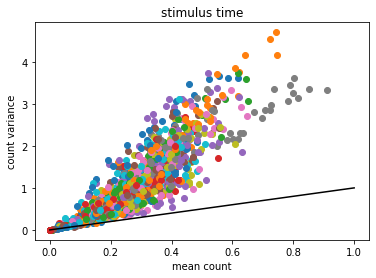

In [16]:
binLen = 5*dt

for mi in range(len(Mean_list)):
    for ci in range(len(Contrast_list)):
        Spike_Cell = Data2DList[mi][ci]['Spike_Cell'].copy()

        totalEntropy_Cell = [0]*60
        noiseEntropy_Cell = [0]*60
        for cn in range(60):
            Spike = Spike_Cell[cn]

            rstate_Trial = [0]*trial
            for i in range(trial):
                startTime = restTime+i*(restTime+stiTime)
                endTime = (i+1)*(restTime+stiTime)
                try:
                    Spike_Trial = Spike[np.where(Spike>=startTime)[0][0]:np.where(Spike<endTime)[0][-1]]-startTime
                    rstate_Trial[i], _ = np.histogram(Spike_Trial, np.arange(0,stiTime+binLen,binLen))
                except: # if there is no spike
                    rstate_Trial[i] = np.zeros(int(stiTime/binLen))

            plt.scatter( np.mean(np.array(rstate_Trial).flatten()), np.var(np.array(rstate_Trial).flatten()))

plt.plot([0, 20*binLen], [0, 20*binLen], 'k')
plt.xlabel('mean count')
plt.ylabel('count variance')
plt.title('stimulus time')

Text(0.5, 1.0, 'at rest')

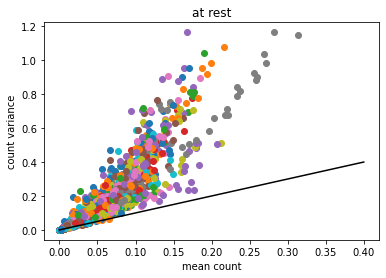

In [17]:
for mi in range(len(Mean_list)):
    for ci in range(len(Contrast_list)):
        Spike_Cell = Data2DList[mi][ci]['Spike_Cell'].copy()

        totalEntropy_Cell = [0]*60
        noiseEntropy_Cell = [0]*60
        for cn in range(60):
            Spike = Spike_Cell[cn]

            rstate_Trial = [0]*trial
            for i in range(trial):
                startTime = i*(restTime+stiTime)
                endTime = restTime+i*(restTime+stiTime)
                try:
                    Spike_Trial = Spike[np.where(Spike>=startTime)[0][0]:np.where(Spike<endTime)[0][-1]]-startTime
                    rstate_Trial[i], _ = np.histogram(Spike_Trial, np.arange(0,stiTime+binLen,binLen))
                except: # if there is no spike
                    rstate_Trial[i] = np.zeros(int(stiTime/binLen))

            plt.scatter( np.mean(np.array(rstate_Trial).flatten()), np.var(np.array(rstate_Trial).flatten()))

plt.plot([0, 8*binLen], [0, 8*binLen], 'k')
plt.xlabel('mean count')
plt.ylabel('count variance')
plt.title('at rest')